In [28]:
import numpy as np
import librosa

In [29]:
MEDIA_FILE='D:\sound_project\sound_preprocessing\Georgia Wonder - Siren.stem_(Instrumental)_model_bs_roformer_ep_317_sdr_12.wav'

In [30]:
y, sr=librosa.load(MEDIA_FILE)

In [31]:
# 3. 

tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)


print(f'Estimated tempo: {tempo} BPM')

for beat in beat_frames:
    print(f'Beat frame: {beat}, Time: {librosa.frames_to_time(beat, sr=sr)} seconds')

Estimated tempo: [112.34714674] BPM
Beat frame: 175, Time: 4.063492063492063 seconds
Beat frame: 198, Time: 4.597551020408163 seconds
Beat frame: 221, Time: 5.131609977324263 seconds
Beat frame: 243, Time: 5.642448979591837 seconds
Beat frame: 266, Time: 6.176507936507937 seconds
Beat frame: 289, Time: 6.710566893424036 seconds
Beat frame: 312, Time: 7.244625850340136 seconds
Beat frame: 335, Time: 7.778684807256236 seconds
Beat frame: 358, Time: 8.312743764172335 seconds
Beat frame: 380, Time: 8.823582766439909 seconds
Beat frame: 403, Time: 9.357641723356009 seconds
Beat frame: 426, Time: 9.891700680272109 seconds
Beat frame: 449, Time: 10.425759637188209 seconds
Beat frame: 472, Time: 10.95981859410431 seconds
Beat frame: 495, Time: 11.493877551020407 seconds
Beat frame: 518, Time: 12.027936507936507 seconds
Beat frame: 541, Time: 12.561995464852608 seconds
Beat frame: 563, Time: 13.072834467120181 seconds
Beat frame: 586, Time: 13.606893424036281 seconds
Beat frame: 609, Time: 14.1

In [32]:
hop_length = 512


In [33]:
# Compute MFCC features from the raw signal

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)


# And the first-order differences (delta features)

mfcc_delta = librosa.feature.delta(mfcc)

print(f'MFCC shape: {mfcc.shape}')
print(f'MFCC Delta shape: {mfcc_delta.shape}')

MFCC shape: (13, 18528)
MFCC Delta shape: (13, 18528)


In [34]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [35]:
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)

print(f'Beat-synchronous MFCC + Delta shape: {beat_mfcc_delta.shape}')

Beat-synchronous MFCC + Delta shape: (26, 799)


In [36]:
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,sr=sr)

print(f'Chromagram shape: {chromagram.shape}')

Chromagram shape: (12, 18528)


In [37]:
# Aggregate chroma features between beat events

# We'll use the median value of each feature between beat frames

beat_chroma = librosa.util.sync(chromagram,beat_frames,aggregate=np.median)

print(f'Beat-synchronous chromagram shape: {beat_chroma.shape}')

Beat-synchronous chromagram shape: (12, 799)


In [38]:
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

print(f'Combined beat-synchronous features shape: {beat_features.shape}')

Combined beat-synchronous features shape: (38, 799)


In [ ]:
print(beat_features[0])

[0.4010421  0.20285086 0.30625066 0.31947657 0.32100776 0.39826298
 0.40077296 0.40881792 1.         0.15699482 0.06600624 0.08778172
 0.12234259 0.08914232 0.09750476 1.         1.         0.48752958
 0.56915104 0.69575083 0.26473334 0.4161382  0.31174117 0.42979175
 0.27389994 0.29268202 0.20771085 0.34399444 0.26966876 0.2335765
 0.20887694 0.25677103 1.         0.23800172 0.31887382 0.36883497
 0.30710658 0.24918266 0.27570528 0.34472057 1.         0.1516251
 0.08132521 0.07464577 0.0986215  0.07262814 0.11096687 1.
 0.99857044 0.38649395 0.52589434 0.84499115 0.34318647 0.54736894
 0.3409849  0.46462017 0.2559291  0.19958036 0.3336049  0.24528559
 0.29082707 0.2141268  0.2780623  0.44859758 0.28792512 0.22789267
 0.40596777 0.37433594 0.27715564 0.35964835 0.47367853 0.39851996
 1.         0.13015847 0.05706448 0.09299944 0.12597045 0.08607696
 0.08305975 1.         0.924421   0.35564405 0.3861377  0.48292744
 0.24175061 0.28743178 0.31943294 0.33211902 0.23168764 0.29967985
 0.25

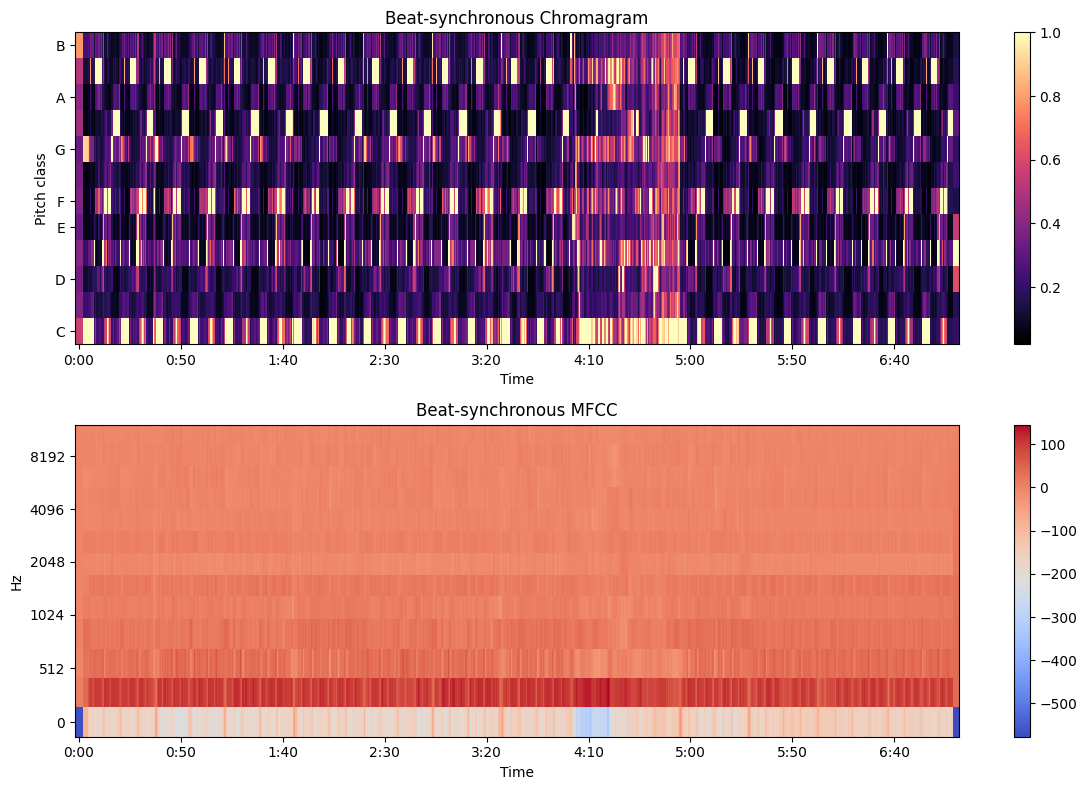

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# 1. 'Vá' lại beat_frames để có mốc bắt đầu (0) và mốc kết thúc (T)
# Giả sử 'y' là tín hiệu âm thanh của bạn
T_frames = librosa.time_to_frames(librosa.get_duration(y=y, sr=sr), sr=sr, hop_length=hop_length)
fixed_beat_frames = librosa.util.fix_frames(beat_frames, x_min=0, x_max=T_frames)

# 2. Thực hiện sync lại với danh sách khung hình đã vá
# Kết quả sẽ có số cột ít hơn số khung hình đúng 1 đơn vị
beat_chroma_sync = librosa.util.sync(chromagram, fixed_beat_frames, aggregate=np.median)
beat_mfcc_sync = librosa.util.sync(mfcc, fixed_beat_frames)

# 3. Tạo mảng thời gian cho trục X (sẽ có len = len(fixed_beat_frames))
beat_times = librosa.frames_to_time(fixed_beat_frames, sr=sr, hop_length=hop_length)

# 4. Vẽ đồ thị
plt.figure(figsize=(12, 8))

# Vẽ Chroma
plt.subplot(2, 1, 1)
# C (12, 539) | X (540) | Y mặc định (13 vạch cho 12 nốt) -> Khớp!
librosa.display.specshow(beat_chroma_sync, y_axis='chroma', x_axis='time', 
                         x_coords=beat_times)
plt.colorbar()
plt.title('Beat-synchronous Chromagram')

# Vẽ MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(beat_mfcc_sync, y_axis='mel', x_axis='time', 
                         x_coords=beat_times)
plt.colorbar()
plt.title('Beat-synchronous MFCC')

plt.tight_layout()
plt.show()